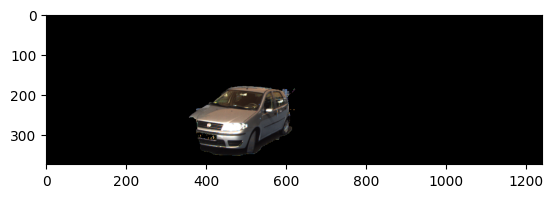

In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('/home/lab530/KenYu/kitti/training/image_2/000008.png')

mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (334, 178, 290, 194) # (xmin, ymin, width, height)

cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.show()

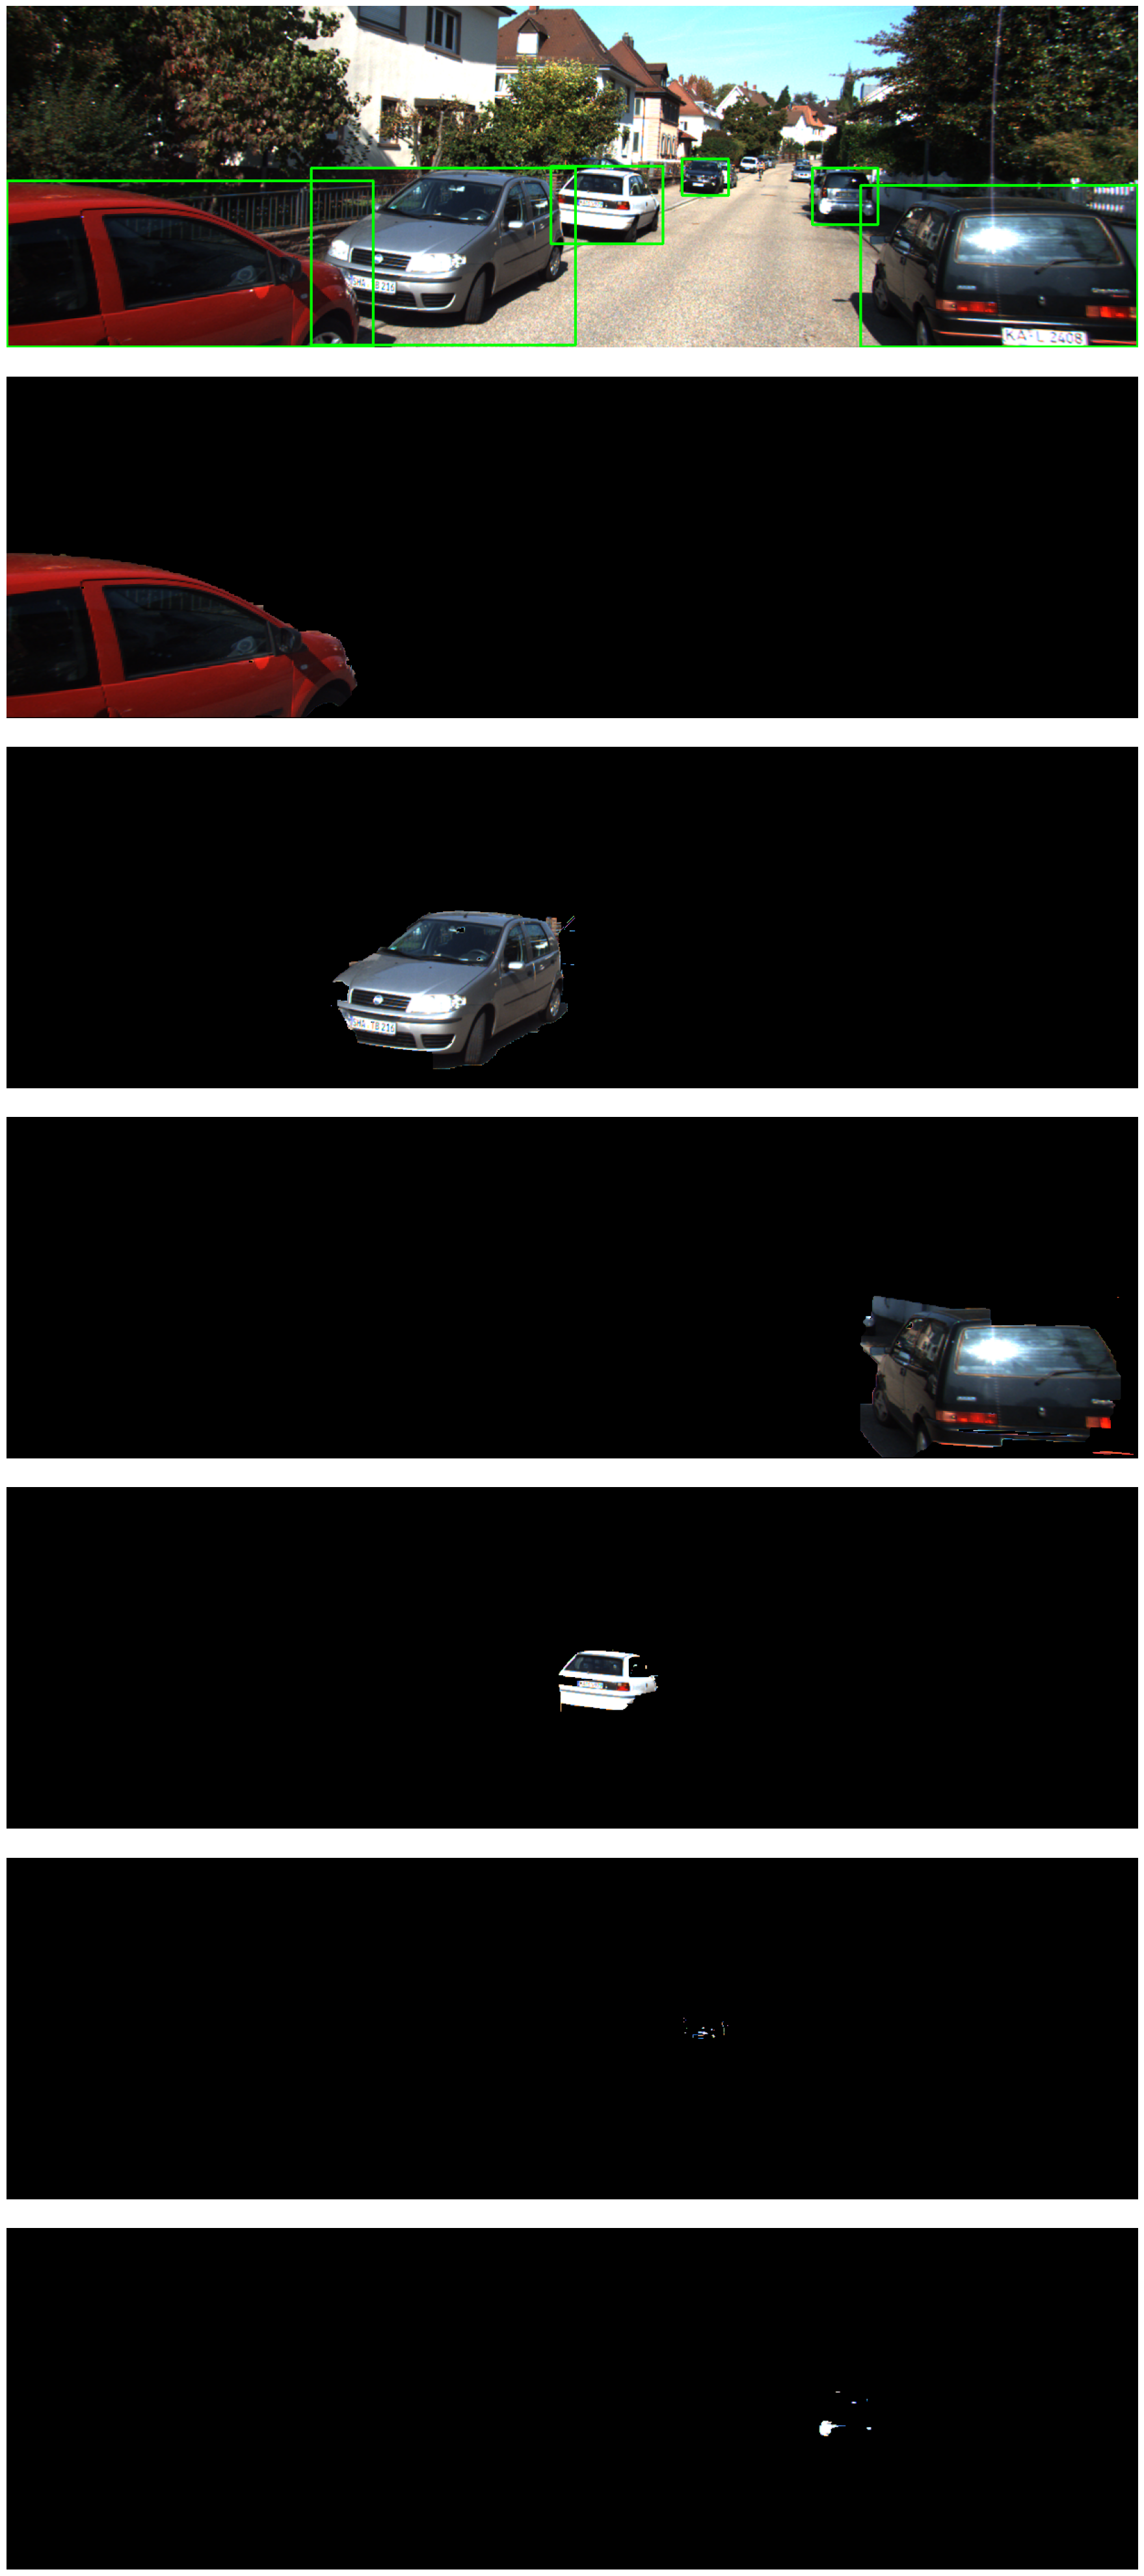

In [12]:
import numpy as np
import os
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.gridspec import GridSpec
from PIL import Image
from shutil import rmtree
import cv2

class Object:
    def __init__(self, str_line, idx_img = None):
        # str_line should be 'Car 0.00 0 -1.58 587.19 178.91 603.38 191.75 1.26 1.60 3.56 -1.53 1.89 73.44 -1.60'
        self.idx_img = idx_img # this obj belong to which image 
        self.raw_str = str_line
        sl = str_line.split()
        self.category, self.truncated, self.occluded, self.alpha = sl[0], float(sl[1]), int(sl[2]), float(sl[3])
        self.x_min, self.y_min, self.x_max, self.y_max = [int(float(i)) for i in sl[4:8]]
        self.h, self.w, self.l = [float(i) for i in sl[8:11]]
        self.x_3d, self.y_3d, self.z_3d = [float(i) for i in sl[11:14]]
        self.rot_y = float(sl[14])
        self.area = (self.x_max - self.x_min) * (self.y_max - self.y_min)

def draw_2Dbox(ax, line, color):
    x1, y1, x2, y2 = (int(float(line[4])), int(float(line[5])), int(float(line[6])), int(float(line[7])))
    width  = x2 - x1
    height = y2 - y1
    front_fill = patches.Rectangle((x1, y1),
                                    width, 
                                    height, 
                                    fill=False, 
                                    color=color, 
                                    linewidth=1,
                                    alpha=1)
    ax.add_patch(front_fill)

# Load source gt objects
with open('/home/lab530/KenYu/kitti/training/label_2/000008.txt') as f:
    gt_lines = f.read().splitlines()
    gt_lines = list(gt_lines for gt_lines in gt_lines if gt_lines) # Delete empty lines
    gts = [Object(gt) for gt in gt_lines]

# Filter non car objects 
gts_tmp  = []
for gt in gts:
    if gt.category == 'Car':
        gts_tmp.append(gt)
gts = gts_tmp

# Load image 
img = cv2.imread('/home/lab530/KenYu/kitti/training/image_2/000008.png')

# Get segmentation in boudning box
img_seg = []
for gt in gts: 
    rect = (gt.x_min, gt.y_min, gt.x_max - gt.x_min, gt.y_max - gt.y_min) # (xmin, ymin, width, height)
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_seg.append(img*mask2[:,:,np.newaxis])

# Draw 2d bounding box 
for gt in gts:
    cv2.rectangle(img, (int(gt.x_min), int(gt.y_min)), (int(gt.x_max), int(gt.y_max)), (0, 255, 0), 2)

# 
fig, ax = plt.subplots(len(gts)+1, 1, figsize=(20, 40))
fig.set_facecolor('white')
fig.tight_layout()
ax[0].axis('off')
ax[0].imshow(img[...,::-1])

for img_idx in range(1, len(gts)+1):
    ax[img_idx].axis('off')
    ax[img_idx].imshow(img_seg[img_idx-1][...,::-1])